In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize

%matplotlib inline

In [147]:
# assumes periodic BCs
def metropolis_ising(init, boltz):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # applying the metropolis algorithm
    spin_sum = int(mesh[(y+1) % Y,x ] + mesh[y ,(x+1) % X] + mesh[(y-1) % Y,x ] + mesh[y ,(x-1) % X])
    d_energy = 2*mesh[y,x] * spin_sum
    
    if d_energy <= 0:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    else:
        d_energy = 0
        d_mag = 0
        

    return [mesh, d_energy, d_mag]

In [32]:
def plot_ising_grid(init, title):
    """Creates a discrete colormap for an input Ising grid, red for up (1) and blue for down (-1)"""
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    display.clear_output(wait = True)

    plt.show()

In [4]:
def mc_step(init, boltz, n, plot = False, final_only = False):
    """Plots n-step evolution of an Ising model using Metropolis and returns the final grid"""
    
    grid = init[:,:]
    
    for i in range(n):    
        # evolve using metropolis
        evo = metropolis_ising(grid, boltz)[0]
        
        if plot == True:
            # plotting
            if final_only == False:    
                plot_ising_grid(evo, f'2D Ising Model; n = {i+1}')


            else:
                if i == n-1:
                    plot_ising_grid(evo, f'2D Ising Model; n = {i+1}')
        
        # reset iteration variable
        grid = evo[:,:]
        
    return grid

In [139]:
# variant of the above that only returns the grid after 1 sweep
# faster than the single-step program when simulating for very long times
def mc_sweep_af(init, boltz):
    
    grid = init[:,:]
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y ,(x+1) % X] + grid[(y-1) % Y,x ] + grid[y ,(x-1) % X]
            d_energy = -2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]
              #  d_mag = 2*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
            #    d_mag = 2*grid[y,x]

           # else:
           #     d_energy = 0
           #     d_mag = 0
        
    return grid
                
    

In [20]:
# variant of the above that only returns the grid after 1 sweep
# faster than the single-step program when simulating for very long times
def mc_sweep(init, boltz):
    
    grid = init[:,:]
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y ,(x+1) % X] + grid[(y-1) % Y,x ] + grid[y ,(x-1) % X]
            d_energy = 2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]
              #  d_mag = 2*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
            #    d_mag = 2*grid[y,x]

           # else:
           #     d_energy = 0
           #     d_mag = 0
        
    return grid
                
    

In [72]:
def mult_sweeps(init, boltz, N, plot = False, title = None):
    """Similar to mc_sweep, but plotting per sweep"""
    
    grid = copy.copy(init)
    
    for n in range(N):
        mc_sweep(grid, boltz)
    
    if plot == True:
        plot_ising_grid(grid, title)
        
    return grid

In [141]:
def mult_sweeps_af(init, boltz, N, plot = False, title = None):
    """Similar to mc_sweep, but plotting per sweep"""
    
    grid = copy.copy(init)
    
    for n in range(N):
        mc_sweep_af(grid, boltz)
    
    if plot == True:
        plot_ising_grid(grid, title)
        
    return grid

In [6]:
def ising_energy(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1 * init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy

In [ ]:
def energy_evo(init, boltz, n, plot = True):
    """Returns a list of energies for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = init[:,:]
    
    # energy
    energy = ising_energy(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment energy
        energy += d_energy
        energy_list.append(energy)
    
        # reset iteration variable
        grid = evo[:,:]
    
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list

In [102]:
def energy_evo_sweep(init, boltz, N, plot = True):
    """Same as energy_evo, but built on sweeps"""

    grid = copy.copy(init)
    
    # energy
    energy = ising_energy(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(N):
        mc_sweep(grid, boltz)
        energy_list.append(ising_energy(grid))
    
    if plot == True:
        # plotting
        x_axis = [i for i in range(N+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list


In [8]:
def magps(init, boltz, n, plot = True):
    """Returns a list of mag. per spin for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = init[:,:]
    
    # magnetization
    mag = np.sum(grid)
    mag_list = [mag/total]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment magnetization
        mag += d_mag
        mag_list.append(mag/total)
    
        # reset iteration variable
        grid = evo[:,:]

    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,mag_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Magnetization per Spin', fontsize=20)
        plt.title(f'Magnetization per Spin of Ising Grid', fontsize=20)
    
    
    return mag_list

In [92]:
random.seed(1)
test = np.random.randint(2, size=(70, 70))

for i in range(70):
    for j in range(70):
        if test[i,j] == 0:
            test[i,j] = -1

In [93]:
init = test[:,:]

T = 0.01
test_boltz = {"4" : np.exp(-8/T), "2" : np.exp(-4/T)}

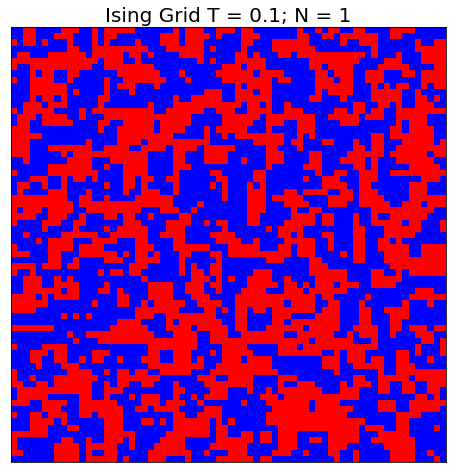

array([[-1, -1,  1, ..., -1, -1, -1],
       [-1, -1,  1, ..., -1, -1, -1],
       [ 1, -1,  1, ..., -1,  1,  1],
       ...,
       [ 1, -1, -1, ..., -1, -1, -1],
       [ 1,  1, -1, ...,  1, -1, -1],
       [-1, -1, -1, ..., -1,  1, -1]])

In [140]:
mult_sweeps(init, test_boltz, 1, plot = True, title = 'Ising Grid T = 0.1; N = 1',)

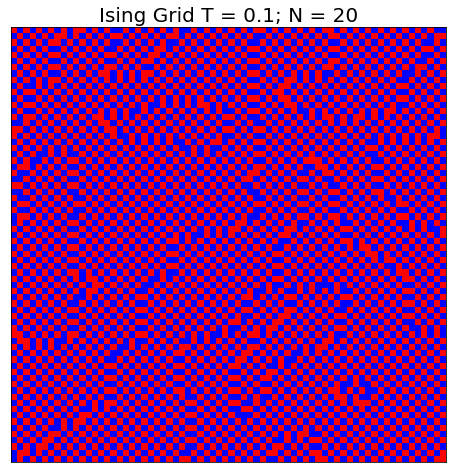

array([[ 1., -1.,  1., ...,  1., -1., -1.],
       [-1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1., -1.,  1., ..., -1.,  1., -1.],
       ...,
       [ 1., -1.,  1., ..., -1.,  1., -1.],
       [-1.,  1.,  1., ...,  1., -1.,  1.],
       [-1.,  1., -1., ..., -1.,  1.,  1.]])

In [152]:
random.seed(1)
mult_sweeps_af(ones, test_boltz, 20, plot = True, title = 'Ising Grid T = 0.1; N = 20',)